In [1]:
import numpy as np
import sqil_core as sqil
from scipy.optimize import curve_fit, minimize, newton
import matplotlib.pyplot as plt

import scipy.optimize as spopt
from scipy import stats
from scipy.linalg import norm

In [2]:
# Deep
deep = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00075-cavity_check_2024-12-12T171954'
# Tiny
tiny = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00032-cavity_check_2024-12-12T144742'
# Good
good = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00077-cavity_check_2024-12-12T172355'
# Bad
bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00062-cavity_check_2024-12-12T160601'
# Very bad
very_bad = r'Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00053-cavity_check_2024-12-12T155026'

My helpers

In [3]:
def estimate_linear_background(x: np.ndarray, data: np.ndarray, points_cut = 0.1) -> list:
    is1D = len(data.shape) == 1
    points = data.shape[0] if is1D else data.shape[1]
    cut = int(points * points_cut)

    # Consider just the cut points
    x_data = x[0:cut] if is1D else x[0:cut,:]
    X = np.vstack([np.ones_like(x_data), x_data]).T
    y_data = data[0:cut] if is1D else data[0:cut,:]

    # Linear fit
    coefficients, residuals, _, _ = np.linalg.lstsq(
        X, y_data if is1D else y_data.T, rcond=None)

    return coefficients


def compute_global_2pi_shift(phase, phase_tmp, make_integer = True):
    """Compute the single global 2pi shift n that best aligns `phase` with `phase_tmp`."""
    delta_phase = phase - phase_tmp
    n = np.mean(delta_phase) / (2 * np.pi)
    return int(np.round(n)) if make_integer else n

Reviewed Taketo functions

In [4]:
def shift_phase(phase):
    """
    Shifts the (unwrapped) phase data so that the first phase value
    lies within the range (-pi, pi].

    Parameters:
    phase (array-like): Unwrapped phase data.

    Returns:
    array-like: Phase data shifted to the range (-pi, pi].
    """
    # Calculate how many 2*pi shifts are required to bring phase[0] into (-pi, pi]
    n = np.round(phase[0] / (2 * np.pi))

    # Shift the entire phase array
    return phase - 2 * n * np.pi

def fit_phase_vs_freq_taketo(freq, phase, theta_0 = None, Q_tot = None, f_r = None):
    if theta_0 is None:
        theta_0 = np.mean(phase)
    if Q_tot is None:
        Q_tot = 0.01
    if f_r is None:
        f_r = np.mean(freq) #freq[np.argmin(np.abs(phase - np.mean(phase)))]

    def objective(x):
        theta_0, Q_tot, f_r = x
        model = theta_0 + 2 * np.arctan(2 * Q_tot * (1 - freq / f_r))
        residuals = phase - model
        return np.square(residuals).sum()

    res = minimize(
        fun=objective,
        x0=[theta_0, Q_tot, f_r],
        method="Nelder-Mead",
        options={
            "maxiter": 3000000,
            "disp": True
        }
    )

    theta_0, Q_tot, f_r = res.x
    return theta_0, Q_tot, f_r

def S11_reflection(freq, a, alpha, tau, Q_tot, Q_ext, f_r, phi):
    env = a * np.exp(1j * alpha) * np.exp(2j * np.pi * (freq - freq[0]) * tau)
    resonator = 1 - (2 * Q_tot / np.abs(Q_ext)) * np.exp(1j * phi) / (1 + 2j * Q_tot * (freq / f_r - 1))
    return env * resonator

def S11_reflection_mesh(freq, a, alpha, tau, Q_tot, Q_ext, f_r, phi):
    """
    Vectorized S11 reflection function.

    Parameters
    ----------
    freq : array, shape (N,)
        Frequency points.
    a, alpha, tau, Q_tot, Q_ext, f_r, phi : scalar or array
        Parameters of the S11 model.

    Returns
    -------
    S11 : array
        Complex reflection coefficient. Shape is (M1, M2, ..., N) where M1, M2, ... are the broadcasted shapes of the parameters.
    """
    # Ensure freq is at least 2D for broadcasting (1, N)
    freq = np.atleast_1d(freq)  # (N,)

    # Ensure all parameters are at least 1D arrays for broadcasting
    a = np.atleast_1d(a)  # (M1,)
    alpha = np.atleast_1d(alpha)  # (M2,)
    tau = np.atleast_1d(tau)  # (M3,)
    Q_tot = np.atleast_1d(Q_tot)  # (M4,)
    Q_ext = np.atleast_1d(Q_ext)  # (M5,)
    f_r = np.atleast_1d(f_r)  # (M6,)
    phi = np.atleast_1d(phi)  # (M7,)

    # Reshape frequency to (1, 1, ..., 1, N) for proper broadcasting
    freq = freq[np.newaxis, ...]  # This makes sure freq has shape (1, 1, ..., N)

    # Calculate the envelope part
    env = a[..., np.newaxis] * np.exp(1j * alpha[..., np.newaxis]) * np.exp(2j * np.pi * (freq - freq[..., 0:1]) * tau[..., np.newaxis])

    # Calculate the resonator part
    resonator = 1 - (2 * Q_tot[..., np.newaxis] / np.abs(Q_ext[..., np.newaxis])) * np.exp(1j * phi[..., np.newaxis]) / (1 + 2j * Q_tot[..., np.newaxis] * (freq / f_r[..., np.newaxis] - 1))

    return env * resonator

From KIT

In [5]:
def get_delay(f_data,z_data,delay=None,ignoreslope=True,guess=True):
    '''
    ignoreslope option not used here
    retrieves the cable delay assuming the ideal resonance has a circular shape
    modifies the cable delay until the shape Im(S21) vs Re(S21) is circular
    see "do_calibration"
    '''
    maxval = np.max(np.absolute(z_data))
    z_data = z_data/maxval
    A1, A2, A3, A4, fr, Ql = fit_skewed_lorentzian(f_data,z_data)
    if ignoreslope==True:
        A2 = 0
    else:
        z_data = (np.sqrt(np.absolute(z_data)**2-A2*(f_data-fr))) * np.exp(np.angle(z_data)*1j)  #usually not necessary
    if delay==None:
        if guess==True:
            delay = guess_delay(f_data,z_data)
        else:
            delay=0.
        delay = fit_delay(f_data,z_data,delay,maxiter=200)
    params = [A1, A2, A3, A4, fr, Ql]
    return delay, params

def fit_skewed_lorentzian(f_data, z_data):
    amplitude = np.absolute(z_data)
    amplitude_sqr = amplitude**2
    A1a = np.minimum(amplitude_sqr[0],amplitude_sqr[-1])
    A3a = -np.max(amplitude_sqr)
    fra = f_data[np.argmin(amplitude_sqr)]
    def residuals(p,x,y):
        A2, A4, Ql = p
        err = y -(A1a+A2*(x-fra)+(A3a+A4*(x-fra))/(1.+4.*Ql**2*((x-fra)/fra)**2))
        return err
    p0 = [0., 0., 1e3]
    p_final = spopt.leastsq(residuals,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    A2a, A4a, Qla = p_final[0]

    def residuals2(p,x,y):
        A1, A2, A3, A4, fr, Ql = p
        err = y -(A1+A2*(x-fr)+(A3+A4*(x-fr))/(1.+4.*Ql**2*((x-fr)/fr)**2))
        return err
    p0 = [A1a, A2a , A3a, A4a, fra, Qla]
    p_final = spopt.leastsq(residuals2,p0,args=(np.array(f_data),np.array(amplitude_sqr)))
    #A1, A2, A3, A4, fr, Ql = p_final[0]
    #print(p_final[0][5])
    return p_final[0]


def guess_delay(f_data,z_data):
    phase2 = np.unwrap(np.angle(z_data))
    gradient, intercept, r_value, p_value, std_err = stats.linregress(f_data,phase2)
    return gradient*(-1.)/(np.pi*2.)


def fit_delay(f_data,z_data,delay=0.,maxiter=0):
    def residuals(p,x,y):
        phasedelay = p
        z_data_temp = y*np.exp(1j*(2.*np.pi*phasedelay*x))
        xc,yc,r0 = fit_circle_algebraic(z_data_temp)
        err = np.sqrt((z_data_temp.real-xc)**2+(z_data_temp.imag-yc)**2)-r0
        return err
    p_final = spopt.leastsq(residuals,delay,args=(f_data,z_data),maxfev=maxiter,ftol=1e-12,xtol=1e-12)
    return p_final[0][0]

def fit_circle_algebraic(z_data):
    def calc_moments(z_data):
        xi = z_data.real
        xi_sqr = xi*xi
        yi = z_data.imag
        yi_sqr = yi*yi
        zi = xi_sqr+yi_sqr
        Nd = float(len(xi))
        xi_sum = xi.sum()
        yi_sum = yi.sum()
        zi_sum = zi.sum()
        xiyi_sum = (xi*yi).sum()
        xizi_sum = (xi*zi).sum()
        yizi_sum = (yi*zi).sum()
        return np.array([ [(zi*zi).sum(), xizi_sum, yizi_sum, zi_sum],  \
        [xizi_sum, xi_sqr.sum(), xiyi_sum, xi_sum], \
        [yizi_sum, xiyi_sum, yi_sqr.sum(), yi_sum], \
        [zi_sum, xi_sum, yi_sum, Nd] ])

    M = calc_moments(z_data)

    a0 = ((M[2][0]*M[3][2]-M[2][2]*M[3][0])*M[1][1]-M[1][2]*M[2][0]*M[3][1]-M[1][0]*M[2][1]*M[3][2]+M[1][0]*M[2][2]*M[3][1]+M[1][2]*M[2][1]*M[3][0])*M[0][3]+(M[0][2]*M[2][3]*M[3][0]-M[0][2]*M[2][0]*M[3][3]+M[0][0]*M[2][2]*M[3][3]-M[0][0]*M[2][3]*M[3][2])*M[1][1]+(M[0][1]*M[1][3]*M[3][0]-M[0][1]*M[1][0]*M[3][3]-M[0][0]*M[1][3]*M[3][1])*M[2][2]+(-M[0][1]*M[1][2]*M[2][3]-M[0][2]*M[1][3]*M[2][1])*M[3][0]+((M[2][3]*M[3][1]-M[2][1]*M[3][3])*M[1][2]+M[2][1]*M[3][2]*M[1][3])*M[0][0]+(M[1][0]*M[2][3]*M[3][2]+M[2][0]*(M[1][2]*M[3][3]-M[1][3]*M[3][2]))*M[0][1]+((M[2][1]*M[3][3]-M[2][3]*M[3][1])*M[1][0]+M[1][3]*M[2][0]*M[3][1])*M[0][2]
    a1 = (((M[3][0]-2.*M[2][2])*M[1][1]-M[1][0]*M[3][1]+M[2][2]*M[3][0]+2.*M[1][2]*M[2][1]-M[2][0]*M[3][2])*M[0][3]+(2.*M[2][0]*M[3][2]-M[0][0]*M[3][3]-2.*M[2][2]*M[3][0]+2.*M[0][2]*M[2][3])*M[1][1]+(-M[0][0]*M[3][3]+2.*M[0][1]*M[1][3]+2.*M[1][0]*M[3][1])*M[2][2]+(-M[0][1]*M[1][3]+2.*M[1][2]*M[2][1]-M[0][2]*M[2][3])*M[3][0]+(M[1][3]*M[3][1]+M[2][3]*M[3][2])*M[0][0]+(M[1][0]*M[3][3]-2.*M[1][2]*M[2][3])*M[0][1]+(M[2][0]*M[3][3]-2.*M[1][3]*M[2][1])*M[0][2]-2.*M[1][2]*M[2][0]*M[3][1]-2.*M[1][0]*M[2][1]*M[3][2])
    a2 = ((2.*M[1][1]-M[3][0]+2.*M[2][2])*M[0][3]+(2.*M[3][0]-4.*M[2][2])*M[1][1]-2.*M[2][0]*M[3][2]+2.*M[2][2]*M[3][0]+M[0][0]*M[3][3]+4.*M[1][2]*M[2][1]-2.*M[0][1]*M[1][3]-2.*M[1][0]*M[3][1]-2.*M[0][2]*M[2][3])
    a3 = (-2.*M[3][0]+4.*M[1][1]+4.*M[2][2]-2.*M[0][3])
    a4 = -4.

    def func(x):
        return a0+a1*x+a2*x*x+a3*x*x*x+a4*x*x*x*x

    def d_func(x):
        return a1+2*a2*x+3*a3*x*x+4*a4*x*x*x

    x0 = spopt.fsolve(func, 0., fprime=d_func)

    def solve_eq_sys(val,M):
        #prepare
        M[3][0] = M[3][0]+2*val
        M[0][3] = M[0][3]+2*val
        M[1][1] = M[1][1]-val
        M[2][2] = M[2][2]-val
        return np.linalg.svd(M)

    U,s,Vt = solve_eq_sys(x0[0],M)

    A_vec = Vt[np.argmin(s),:]

    xc = -A_vec[1]/(2.*A_vec[0])
    yc = -A_vec[2]/(2.*A_vec[0])
    # the term *sqrt term corrects for the constraint, because it may be altered due to numerical inaccuracies during calculation
    r0 = 1./(2.*np.absolute(A_vec[0]))*np.sqrt(A_vec[1]*A_vec[1]+A_vec[2]*A_vec[2]-4.*A_vec[0]*A_vec[3])

    print(f'Circle fit: xc = {xc}, yc = {yc}, r0 = {r0}')
    return xc, yc, r0



#############################
def phase_fit_kit(f_data,z_data,theta0, Ql, fr):
    phase = np.unwrap(np.angle(z_data)) # ADDED UNWRAPPING
    def residuals_1(p,x,y,Ql):
        theta0, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_2(p,x,y,theta0):
        Ql, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_3(p,x,y,theta0,Ql):
        fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_4(p,x,y,theta0,fr):
        Ql = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    def residuals_5(p,x,y):
        theta0, Ql, fr = p
        err = dist(y - (theta0+2.*np.arctan(2.*Ql*(1.-x/fr))))
        return err
    p0 = [theta0, fr]
    p_final = spopt.leastsq(lambda a,b,c: residuals_1(a,b,c,Ql),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    theta0, fr = p_final[0]
    p0 = [Ql, fr]
    p_final = spopt.leastsq(lambda a,b,c: residuals_2(a,b,c,theta0),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    Ql, fr = p_final[0]
    p0 = fr
    p_final = spopt.leastsq(lambda a,b,c: residuals_3(a,b,c,theta0,Ql),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    fr = float(p_final[0])
    p0 = Ql
    p_final = spopt.leastsq(lambda a,b,c: residuals_4(a,b,c,theta0,fr),p0,args=(f_data,phase))#,ftol=1e-12,xtol=1e-12)
    Ql = float(p_final[0])
    p0 = [theta0, Ql, fr]
    p_final = spopt.leastsq(residuals_5,p0,args=(f_data,phase))
    return p_final[0]

def dist(x):
    np.absolute(x,x)
    c = (x > np.pi).astype(int)
    return x+c*(-2.*x+2.*np.pi)

def periodic_boundary(x,bound):
    return np.fmod(x,bound)-np.trunc(x/bound)*bound

def center(z_data,zc):
    return z_data-zc

In [43]:
[dBmag], [phase], [freq] = sqil.extract_h5_data(bad, ['mag', 'phase', 'frequency'])
linmag = 10**(dBmag/20)
phase = shift_phase(np.unwrap(phase))
data = linmag * np.exp(1j*phase)

Cable delay (linear guess)

(np.float64(-0.869461536504487),
 np.float64(1.0780189967192613),
 np.float64(-0.9881000186557863),
 np.float64(1.0007893487715098))

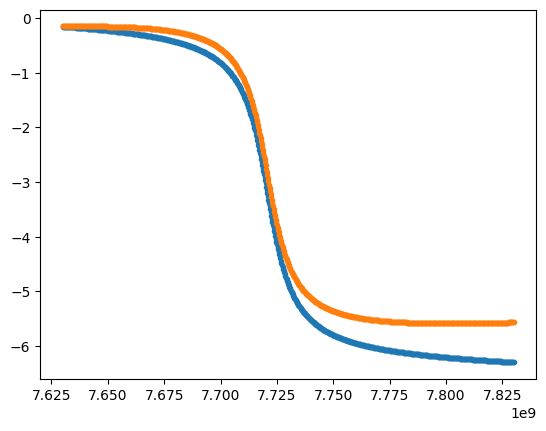

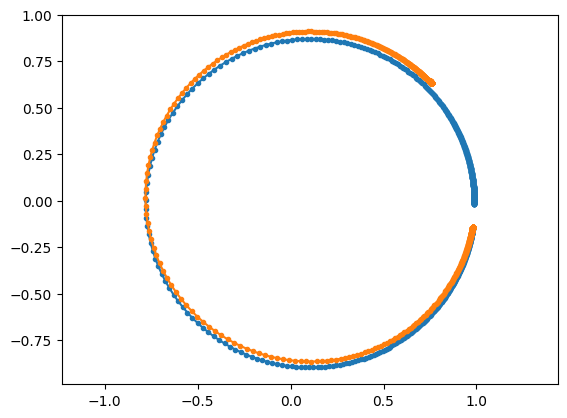

In [44]:
[c, tau] = estimate_linear_background(freq, phase)
tau /= 2*np.pi

# delay = fit_delay(freq,data,tau,maxiter=200)
# delay /= 2*np.pi

# The frequency correction must be relative to the first point we are considering
# In other words, the first point doesn't need to be corrected
phase1 = shift_phase(phase-2*np.pi*tau*(freq - freq[0]))
data1 = linmag * np.exp(1j*phase1)

plt.figure()
plt.plot(freq, phase, '.-')
plt.plot(freq, phase1, '.-')

plt.figure()
plt.plot(np.real(data), np.imag(data), '.-')
plt.plot(np.real(linmag * np.exp(1j*phase1)), np.imag(linmag * np.exp(1j*phase1)), '.-')
plt.axis('equal')

Move circle to center

Circle fit: xc = 0.10811106169363328, yc = 0.024572598632727507, r0 = 0.8883731051578609


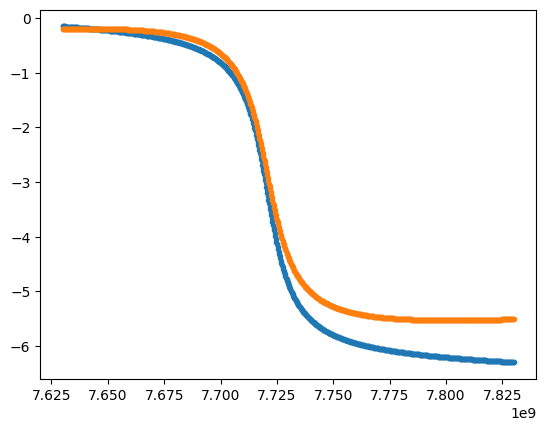

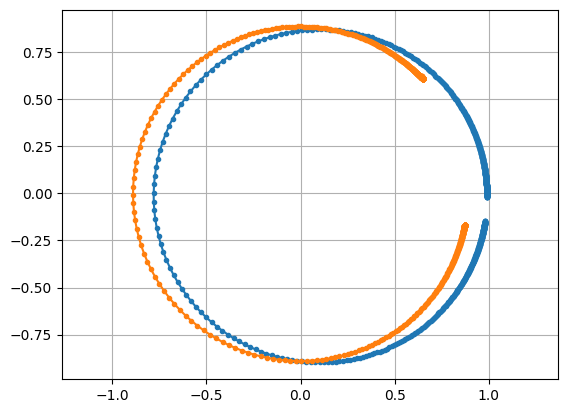

In [45]:
xc, yc, r0 = fit_circle_algebraic(data1)
data3 = data1 - xc - 1j*yc
phase3 = np.unwrap(np.angle(data3))

plt.figure()
plt.plot(freq, phase, '.-')
plt.plot(freq, phase3, '.-')

plt.figure()
plt.plot(np.real(data), np.imag(data), '.-')
plt.plot(np.real(data3), np.imag(data3), '.-')
plt.axis('equal')
plt.grid()

Phase vs freq

In [46]:
theta0, Q_tot, fr = fit_phase_vs_freq_taketo(freq, phase3)
print(theta0, Q_tot, fr)

Optimization terminated successfully.
         Current function value: 14.891430
         Iterations: 391
         Function evaluations: 726
-2.8289187496454673 333.97125251717 7720371653.932282


Calculate the off-resonant point and choose a and alpha

0.99884978137473 0.3027881613974813


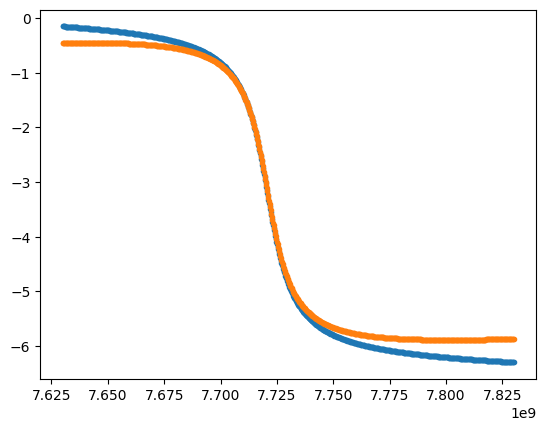

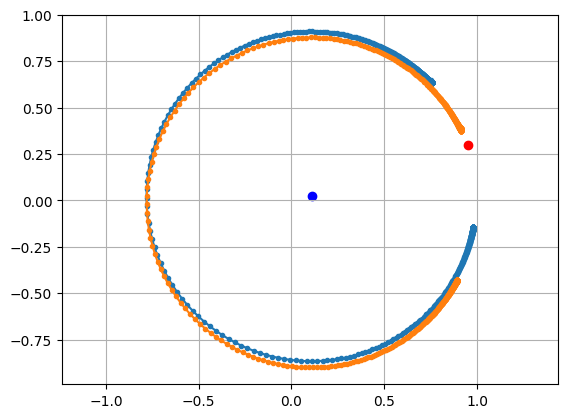

In [47]:
p_offres = (xc+1j*yc) + r0*np.exp(1j*(theta0+np.pi))
a = np.abs(p_offres)
alpha = np.angle(p_offres)

linmag5 = linmag / a
phase5 = phase1 - alpha
data5 = linmag5 * np.exp(1j*phase5)


plt.figure()
plt.plot(freq, phase, '.-')
plt.plot(freq, phase5, '.-')

plt.figure()
plt.plot(np.real(data1), np.imag(data1), '.-')
plt.plot(np.real(data5), np.imag(data5), '.-')
plt.scatter(np.real(p_offres), np.imag(p_offres), color='red')
plt.scatter(xc, yc, color='blue')
plt.axis('equal')
plt.grid()

print(a, alpha)

Impedence mismatch and Q_ext

In [48]:
xc6, yc6, r06 = fit_circle_algebraic(data5)
phi0 = -np.arcsin(yc6/r06)

# FIXME: where does this come from?
Q_ext=Q_tot/(r06*np.exp(-1j*phi0)) # REFLECTION ONLY
Q_int=1/(1/Q_tot-1/np.real(Q_ext))

refl6 = S11_reflection(freq, a, alpha, tau, Q_tot, Q_ext, fr, phi0)
theta0 = phase[0] - np.unwrap(np.angle(refl6))[0]

phi0, Q_ext, Q_int, theta0

Circle fit: xc = 0.11064735393220045, yc = -0.008792197708603455, r0 = 0.8893961051232149


(np.float64(0.009885742546844512),
 np.complex128(375.48504155892454+3.7120693760859074j),
 np.float64(3020.7122145551966),
 np.float64(-0.22501111973535037))

In [49]:
print(
"-----------------------------------------\n" \
+f"Q_total : {Q_tot}\n" \
+f"Q_external : {Q_ext}\n" \
+f"Q_internal : {Q_int}\n" \
+f"resonance freq [Hz] : {fr}\n" \
+f"kappa_tot/2pi [Hz] : {fr/Q_tot}\n" \
+f"kappa_external/2pi [Hz] : {fr/np.real(Q_ext)}\n" \
+f"kappa_internal/2pi [Hz] : {fr/Q_int}\n" \
+f"Phi (Impedance mismatch) : {phi0}\n"
)

-----------------------------------------
Q_total : 333.97125251717
Q_external : (375.48504155892454+3.7120693760859074j)
Q_internal : 3020.7122145551966
resonance freq [Hz] : 7720371653.932282
kappa_tot/2pi [Hz] : 23116874.867950995
kappa_external/2pi [Hz] : 20561063.156814814
kappa_internal/2pi [Hz] : 2555811.711136182
Phi (Impedance mismatch) : 0.009885742546844512



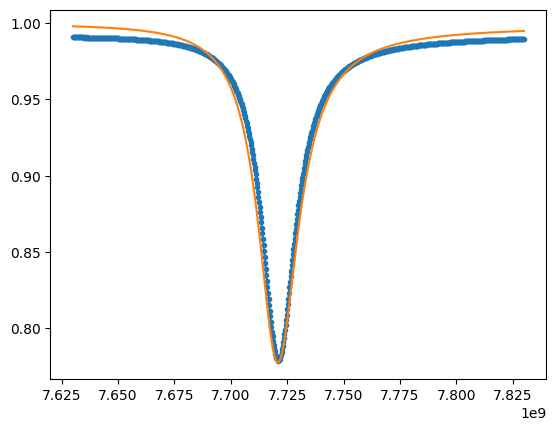

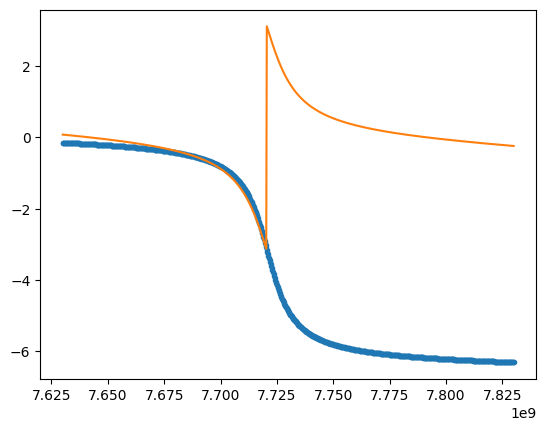

In [50]:
res = S11_reflection(freq,a,alpha,tau,Q_tot,Q_ext,fr,phi0)

plt.figure()
plt.plot(freq, linmag, '.-')
plt.plot(freq, np.abs(res))

plt.figure()
plt.plot(freq, phase, '.-')
plt.plot(freq, np.angle(res))

## The repeatening

Cable delay

-5.827247363606181e-10 -0.22501111973535037
-3.1467292451105774e-10 -0.16835161148451544


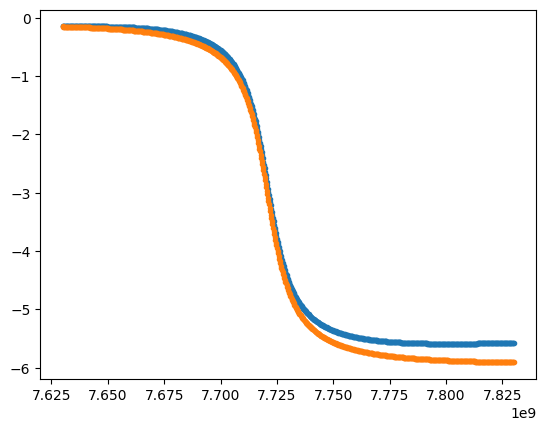

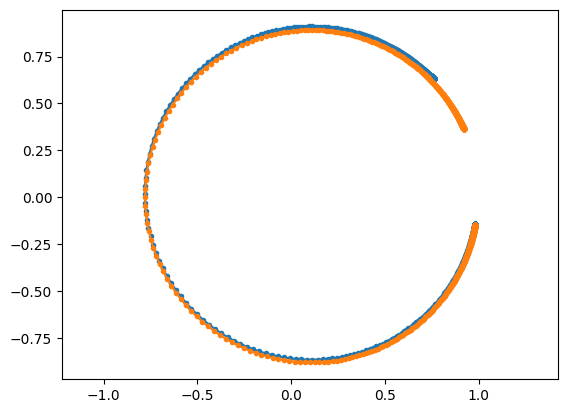

In [51]:
def phase_prediction_error(x):
    tau, theta_0=x
    predicted = S11_reflection(freq,a,alpha,tau,Q_tot,Q_ext,fr,phi0)
    predicted_phase = shift_phase(np.unwrap(np.angle(predicted)))
    return np.sum((phase - predicted_phase - theta_0)**2)

# Minimize the phase prediction error as a function of cable delay (tau)
# and a global phase offset theta_0
res = minimize(fun=phase_prediction_error,
               x0 = [tau, theta0], # initial value
               method = "Nelder-Mead",
               jac = False,
               options={"maxiter":3000000}, # maximum of iteration
               )
new_tau, new_theta0 = res.x

print(tau, theta0)
print(new_tau, new_theta0)

phase8 = shift_phase(phase - 2*np.pi * new_tau * (freq-freq[0]))
data8 = linmag * np.exp(1j * phase8)

plt.figure()
plt.plot(freq, phase1, '.-')
plt.plot(freq, phase8, '.-')

plt.figure()
plt.plot(np.real(data1), np.imag(data1), '.-')
plt.plot(np.real(linmag * np.exp(1j*phase8)), np.imag(linmag * np.exp(1j*phase8)), '.-')
plt.axis('equal');

Move circle to center

Circle fit: xc = 0.10766197235923959, yc = 0.006328418897151019, r0 = 0.8862372885724991


5.048811440883619

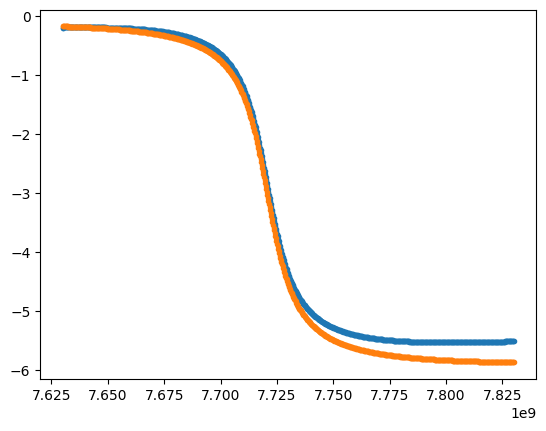

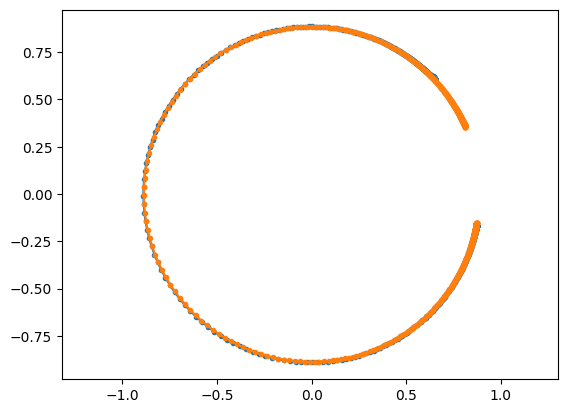

In [52]:
xc9, yc9, r09 = fit_circle_algebraic(data8)

data9 = data8 - (xc9+1j*yc9)
linmag9 = np.abs(data9)
phase9 = shift_phase(np.unwrap(np.angle(data9)))

plt.figure()
plt.plot(freq, phase3, '.-')
plt.plot(freq, phase9, '.-')

plt.figure()
plt.plot(np.real(data3), np.imag(data3), '.-')
plt.plot(np.real(data9), np.imag(data9), '.-')
plt.axis('equal')

norm(data3-data9)

Phase vs frequency fit

In [53]:
print(theta0, Q_tot, fr)
new_theta0, new_Q_tot, new_fr = fit_phase_vs_freq_taketo(freq, phase9)
print(new_theta0, new_Q_tot, new_fr)

-0.22501111973535037 333.97125251717 7720371653.932282
Optimization terminated successfully.
         Current function value: 1.835150
         Iterations: 365
         Function evaluations: 663
-3.0011858355787364 378.0141329369699 7720564877.30637


Find off-resonance point (a and alpha)

0.99884978137473 0.3027881613974813
0.9937643817223956 0.13155076584920644


2.731923301670993

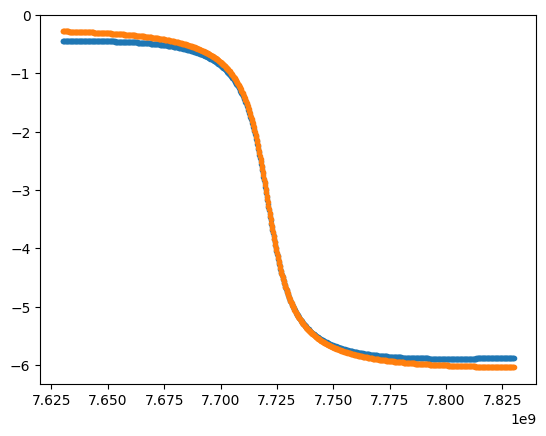

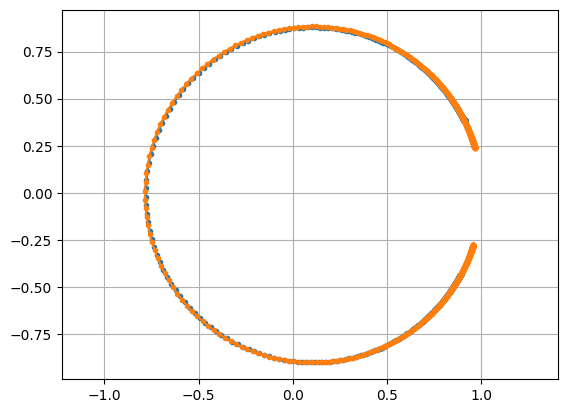

In [54]:
p_offres = (xc9+1j*yc9) + r09*np.exp(1j*(new_theta0+np.pi))
new_a = np.abs(p_offres)
new_alpha = np.angle(p_offres)

linmag10 = linmag / new_a
phase10 = phase8 - new_alpha
data10 = linmag10 * np.exp(1j*phase10)


plt.figure()
plt.plot(freq, phase5, '.-')
plt.plot(freq, phase10, '.-')

plt.figure()
plt.plot(np.real(data5), np.imag(data5), '.-')
plt.plot(np.real(data10), np.imag(data10), '.-')
plt.axis('equal')
plt.grid()

print(a, alpha)
print(new_a, new_alpha)
norm(data5-data10)

Impedence mismatch and Q_ext

In [55]:
xc11, yc11, r011 = fit_circle_algebraic(data10)
new_phi0 = -np.arcsin(yc11/r011)

# FIXME: where does this come from?
new_Q_ext = new_Q_tot/(r011*np.exp(-1j*new_phi0)) # REFLECTION ONLY
new_Q_int = 1/(1/new_Q_tot-1/np.real(new_Q_ext))

refl11 = S11_reflection(freq, new_a, new_alpha, new_tau, new_Q_tot, new_Q_ext, new_fr, new_phi0)
new_theta0 = phase[0] - np.unwrap(np.angle(refl11))[0]

print(phi0, Q_ext, Q_int, theta0)
print(new_phi0, new_Q_ext, new_Q_int, new_theta0)

Circle fit: xc = 0.1082367697470622, yc = -0.007897708155741062, r0 = 0.8917982017391981
0.009885742546844512 (375.48504155892454+3.7120693760859074j) 3020.7122145551966 -0.22501111973535037
0.008856052161850097 (423.861932594991+3.7538415225015953j) 3494.7326181410813 -0.07977920910893826


In [56]:
print(
"-----------------------------------------\n" \
+f"Q_total : {new_Q_tot}\n" \
+f"Q_external : {new_Q_ext}\n" \
+f"Q_internal : {new_Q_int}\n" \
+f"resonance freq [Hz] : {new_fr}\n" \
+f"kappa_tot/2pi [Hz] : {new_fr/new_Q_tot}\n" \
+f"kappa_external/2pi [Hz] : {new_fr/np.real(new_Q_ext)}\n" \
+f"kappa_internal/2pi [Hz] : {new_fr/new_Q_int}\n" \
+f"Phi (Impedance mismatch) : {new_phi0}\n"
)

-----------------------------------------
Q_total : 378.0141329369699
Q_external : (423.861932594991+3.7538415225015953j)
Q_internal : 3494.7326181410813
resonance freq [Hz] : 7720564877.30637
kappa_tot/2pi [Hz] : 20424011.180009764
kappa_external/2pi [Hz] : 18214810.728670772
kappa_internal/2pi [Hz] : 2209200.4513389906
Phi (Impedance mismatch) : 0.008856052161850097



In [57]:
new_a, new_alpha, new_tau, new_Q_tot, new_Q_ext, new_fr, new_phi0

(np.float64(0.9937643817223956),
 np.float64(0.13155076584920644),
 np.float64(-3.1467292451105774e-10),
 np.float64(378.0141329369699),
 np.complex128(423.861932594991+3.7538415225015953j),
 np.float64(7720564877.30637),
 np.float64(0.008856052161850097))

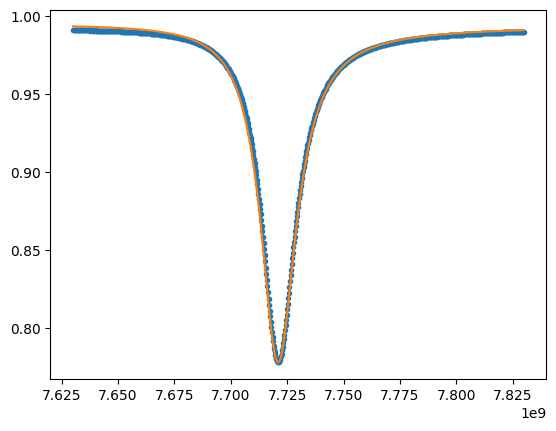

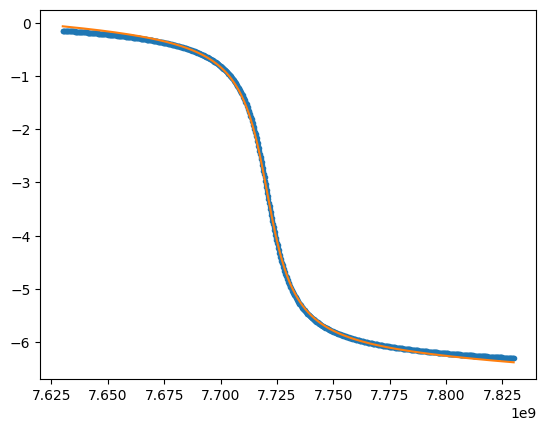

In [58]:
# Fix 2n*pi phase offset
S11 = S11_reflection(freq, new_a, new_alpha, new_tau, new_Q_tot, new_Q_ext, new_fr, new_phi0)

n = compute_global_2pi_shift(phase, np.unwrap(np.angle(S11)))
phase_fit = 2*n*np.pi + np.unwrap(np.angle(S11))

plt.figure()
plt.plot(freq, linmag, '.-')
plt.plot(freq, np.abs(S11))

plt.figure()
plt.plot(freq, phase, '.-')
plt.plot(freq, phase_fit)

## Blushitting

Vectorized S11

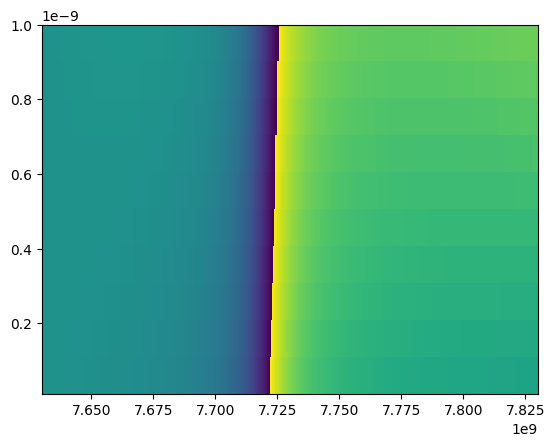

In [59]:
t = np.linspace(1e-11, 1e-9, 10)
Q = np.linspace(1, 1e6, 10)

# plt.plot(freq, S11_reflection_mesh(freq,a,alpha,tau,Q_tot,Q_ext,fr,phi0)[0])

res = S11_reflection_mesh(freq,a,alpha,t,Q_tot,Q_ext,fr,phi0)
plt.imshow(np.angle(res), aspect='auto', extent=[freq[0], freq[-1], t[0], t[-1]],
           origin='lower', cmap='viridis', interpolation='none')


# res = S11_reflection_mesh(freq,a,alpha,t[None,:],Q[None,:],Q_ext,fr,phi0)
# s11_magnitude = np.mean(np.abs(res), axis=2)

# X, Y = np.meshgrid(t, Q)
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, s11_magnitude.T, cmap='viridis')

# ax.set_xlabel('Tau (s)')
# ax.set_ylabel('Q_tot')
# ax.set_zlabel('Average |S11|')
# ax.set_title('3D surface of |S11| as a function of Tau and Q_tot')
# plt.show()

TODO:
- check phase_fit_kit with skewed lorenzian guess
- check kit's rotation to the canonical position